In [1]:
%cd ..
%cd .. 
%cd data

/home/azel/github/Data-Science/jupyter_notebooks
/home/azel/github/Data-Science
/home/azel/github/Data-Science/data


In [20]:
from fin_data import DailyTimeSeries
import numpy as np
import pandas as pd
import os, sys, glob
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import RepeatVector, TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint 

    
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [244]:
apple = DailyTimeSeries('AAPL')
df = apple.initiate()
df.head()

################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  2019-09-04 13:30:09 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################


,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount
date,,,,,,,
1999-09-07,73.750,77.938,73.500,76.375,2.3805,246198400.0,0.0
1999-09-08,76.188,77.688,74.500,74.500,2.3220,190551200.0,0.0
1999-09-09,75.500,75.938,73.875,75.563,2.3552,133520800.0,0.0
1999-09-10,76.000,77.688,74.688,77.438,2.4136,114690800.0,0.0
1999-09-13,77.063,77.063,74.813,75.000,2.3376,63000000.0,0.0


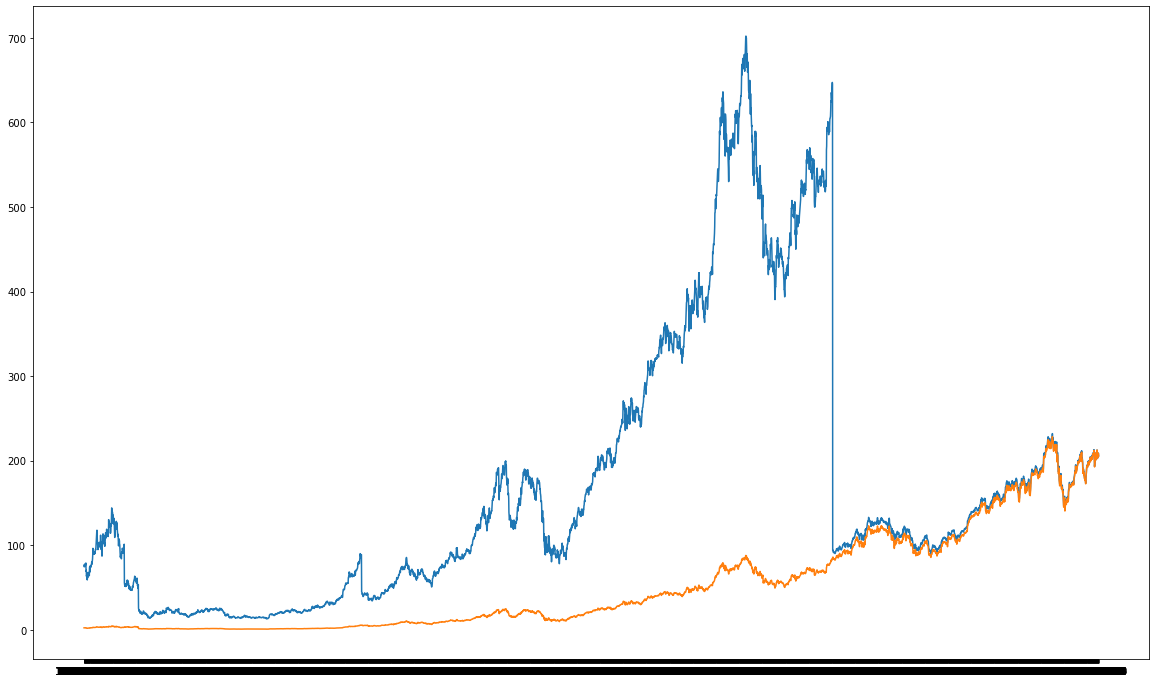

In [176]:
plt.figure(figsize=(20,12))

plt.plot(df['AAPL_close'])
plt.plot(df['AAPL_adjusted_close']);

In [245]:
df['target'] = df['AAPL_adjusted_close'].shift(-1)
#                          df['AAPL_adjusted_close']) / 
#                         (df['AAPL_adjusted_close']))*100


df['target']

df = df.dropna()

In [246]:
X = df.drop(columns='target')
y = df[['target']].values

In [247]:
def split(train_cut, val_cut, X=X, y=y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=train_cut, 
                                                        shuffle=False)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                    train_size=val_cut,
                                                    shuffle=False)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [248]:
X_train, X_test, X_val, y_train, y_test, y_val = split(train_cut=.8,
                                                      val_cut=.6)

Proof that the Train-Test-Split was consecutive instead of shuffled. 

In [249]:
X_train.head()

,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount
date,,,,,,,
1999-09-07,73.750,77.938,73.500,76.375,2.3805,246198400.0,0.0
1999-09-08,76.188,77.688,74.500,74.500,2.3220,190551200.0,0.0
1999-09-09,75.500,75.938,73.875,75.563,2.3552,133520800.0,0.0
1999-09-10,76.000,77.688,74.688,77.438,2.4136,114690800.0,0.0
1999-09-13,77.063,77.063,74.813,75.000,2.3376,63000000.0,0.0


In [250]:
X_train.tail()

,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount
date,,,,,,,
2015-08-27,112.23,113.240,110.020,112.92,105.3863,84616100.0,0.0
2015-08-28,112.17,113.313,111.540,113.29,105.7316,53164400.0,0.0
2015-08-31,112.03,114.530,112.000,112.76,105.2370,56229300.0,0.0
2015-09-01,110.15,111.886,107.360,107.72,100.5332,76845900.0,0.0
2015-09-02,110.23,112.340,109.131,112.34,104.8450,61888800.0,0.0


In [251]:
X_test.head()

,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount
date,,,,,,,
2015-09-03,112.49,112.7800,110.04,110.37,103.0064,53233900.0,0.0
2015-09-04,108.97,110.4500,108.51,109.27,101.9798,49996300.0,0.0
2015-09-08,111.65,112.5600,110.32,112.31,104.8170,54843600.0,0.0
2015-09-09,113.76,114.0200,109.77,110.15,102.8011,85010800.0,0.0
2015-09-10,110.27,113.2825,109.90,112.57,105.0597,62892800.0,0.0


In [252]:
X_test.tail()

,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount
date,,,,,,,
2018-01-19,178.6100,179.58,177.410,178.46,173.7378,32425100.0,0.0
2018-01-22,177.3000,177.78,176.602,177.00,172.3165,27108600.0,0.0
2018-01-23,177.3000,179.44,176.820,177.04,172.3554,32689100.0,0.0
2018-01-24,177.2627,177.30,173.200,174.22,169.6100,51105100.0,0.0
2018-01-25,174.5050,174.95,170.530,171.11,166.5823,41529000.0,0.0


In [253]:
X_val.head()

,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount
date,,,,,,,
2018-01-26,172.000,172.000,170.06,171.51,166.9717,39143000.0,0.0
2018-01-29,170.160,170.160,167.07,167.96,163.5157,50640400.0,0.0
2018-01-30,165.525,167.370,164.70,166.97,162.5519,46048200.0,0.0
2018-01-31,166.870,168.442,166.50,167.43,162.9997,32478900.0,0.0
2018-02-01,167.165,168.620,166.76,167.78,163.3404,47230800.0,0.0


In [254]:
X_val.tail()

,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount
date,,,,,,,
2019-08-27,207.86,208.55,203.53,204.16,204.16,25873300.0,0.0
2019-08-28,204.10,205.72,203.32,205.53,205.53,15938800.0,0.0
2019-08-29,208.50,209.32,206.66,209.01,209.01,20990500.0,0.0
2019-08-30,210.16,210.45,207.20,208.74,208.74,21143400.0,0.0
2019-09-03,206.43,206.98,204.22,205.70,205.70,18213357.0,0.0


In [262]:
def prep_data(train_cut, val_cut, X=X, y=y):
    
    scaler = MinMaxScaler()
    scaler.fit(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=train_cut, 
                                                        shuffle=False)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                    train_size=val_cut,
                                                    shuffle=False)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [263]:
X_train, X_test, X_val, y_train, y_test, y_val = prep_data(train_cut=.8,
                                                           val_cut=.6)

#### TimeSeriesGenerator Params

- **Data:** takes in data argument i.e. X_train, should be 2D, axis 0 is the time dimension and has timesteps. 
- **target:** target for the model i.e. y_train 
- **length:** length of output sequences (in number of timesteps) 
- **sampling_rate:** period between successive timesteps within sequences. 
- **stride:** sequence between successive output sequences. 
- **batch_size:** number of timeseries samples in each batch, i.e. number of days you want to predict the target for. 

##### can also use: 

- **start_index:** data points earlier than start_index would not be used in output sequence, this is to split the data for test or validation. 
- **end_index:** data points later than end_index would not be used in the output sequences, useful to reserve the data for test or validation.

In [265]:
train_data_generator = TimeseriesGenerator(X_train, y_train, 
                                           length=15,
                                           sampling_rate=1, 
                                           stride=1, 
                                           batch_size=6)

test_data_generator = TimeseriesGenerator(X_test, y_test, 
                                          length=15, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=6)

val_data_generator = TimeseriesGenerator(X_val, y_val, 
                                          length=15, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=6)

In [208]:
??TimeseriesGenerator

Init signature:
TimeseriesGenerator(
    data,
    targets,
    length,
    sampling_rate=1,
    stride=1,
    start_index=0,
    end_index=None,
    shuffle=False,
    reverse=False,
    batch_size=128,
)
Source:        
class TimeseriesGenerator(sequence.TimeseriesGenerator, utils.Sequence):
    """Utility class for generating batches of temporal data.

    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.

    # Arguments
        data: Indexable generator (such as list or Numpy array)
            containing consecutive data points (timesteps).
            The data should be at 2D, and axis 0 is expected
            to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`.
        length: Length of the output sequences (in number of timesteps).
      

In [185]:
model = Sequential()
model.add(LSTM(32, input_shape=(train_data_generator.length, X_train.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [186]:
history = model.fit_generator(train_data_generator, 
                              epochs = 20,
                              validation_data=test_data_generator,
                              verbose=1)

Epoch 1/20
668/668 [==============================] - 8s 12ms/step - loss: 1276.8617 - val_loss: 18282.8766
Epoch 2/20
668/668 [==============================] - 7s 10ms/step - loss: 850.6425 - val_loss: 15821.9049
Epoch 3/20
668/668 [==============================] - 7s 10ms/step - loss: 609.5922 - val_loss: 13824.0190
Epoch 4/20
668/668 [==============================] - 6s 9ms/step - loss: 442.3357 - val_loss: 12210.1166
Epoch 5/20
668/668 [==============================] - 6s 9ms/step - loss: 325.1541 - val_loss: 10846.5869
Epoch 6/20
668/668 [==============================] - 6s 9ms/step - loss: 245.7545 - val_loss: 9983.3550
Epoch 7/20
668/668 [==============================] - 6s 9ms/step - loss: 186.1458 - val_loss: 8759.7095
Epoch 8/20
668/668 [==============================] - 6s 9ms/step - loss: 144.6013 - val_loss: 7962.5444
Epoch 9/20
668/668 [==============================] - 6s 9ms/step - loss: 109.5814 - val_loss: 7231.7262
Epoch 10/20
668/668 [=========================

In [187]:
y_pred = model.predict_generator(test_data_generator)

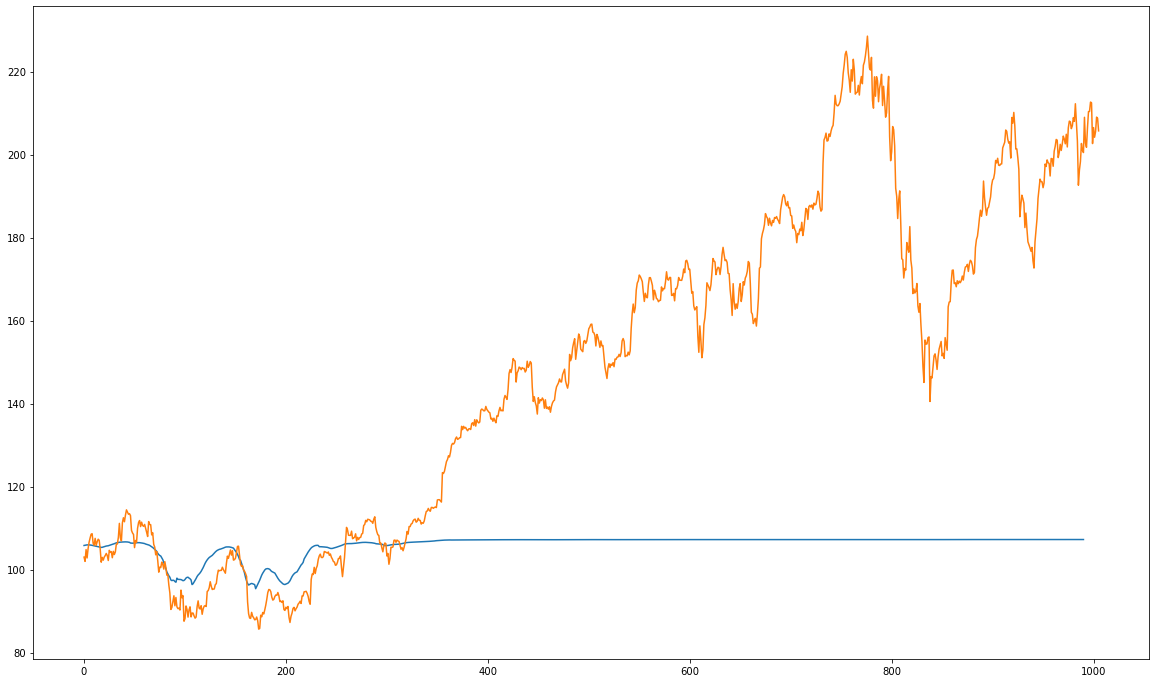

In [188]:
plt.figure(figsize=(20,12))

plt.plot(y_pred)
plt.plot(y_test);

### Now a Deeper Model

In [203]:
%cd .. 
%cd jupyter_notebooks/exploratory_modeling/weights

/Users/azel/github/Data-Science
/Users/azel/github/Data-Science/jupyter_notebooks/exploratory_modeling/weights


In [266]:
model = Sequential()
model.add(LSTM(100, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

checkpointer = ModelCheckpoint(filepath='weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5', 
                               verbose=1, 
                               save_best_only=True)

callbacks_list = [checkpointer]

history_2 = model.fit_generator(train_data_generator, 
                              epochs = 50,
                              validation_data=test_data_generator,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/50
669/669 [==============================] - 27s 41ms/step - loss: 3402.7489 - val_loss: 11408.4227

Epoch 00001: val_loss improved from inf to 11408.42272, saving model to weights-improvement-01-11408.42.hdf5
Epoch 2/50
669/669 [==============================] - 21s 31ms/step - loss: 232.0289 - val_loss: 372.1625

Epoch 00002: val_loss improved from 11408.42272 to 372.16254, saving model to weights-improvement-02-372.16.hdf5
Epoch 3/50
669/669 [==============================] - 20s 30ms/step - loss: 70.7031 - val_loss: 589.6628

Epoch 00003: val_loss did not improve from 372.16254
Epoch 4/50
669/669 [==============================] - 20s 30ms/step - loss: 52.5689 - val_loss: 257.2170

Epoch 00004: val_loss improved from 372.16254 to 257.21702, saving model to weights-improvement-04-257.22.hdf5
Epoch 5/50
669/669 [==============================] - 20s 31ms/step - loss: 52.4056 - val_loss: 168.5369

Epoch 00005: val_loss improved from 257.21702 to 168.53692, saving model to wei

This should show clear overfitting.

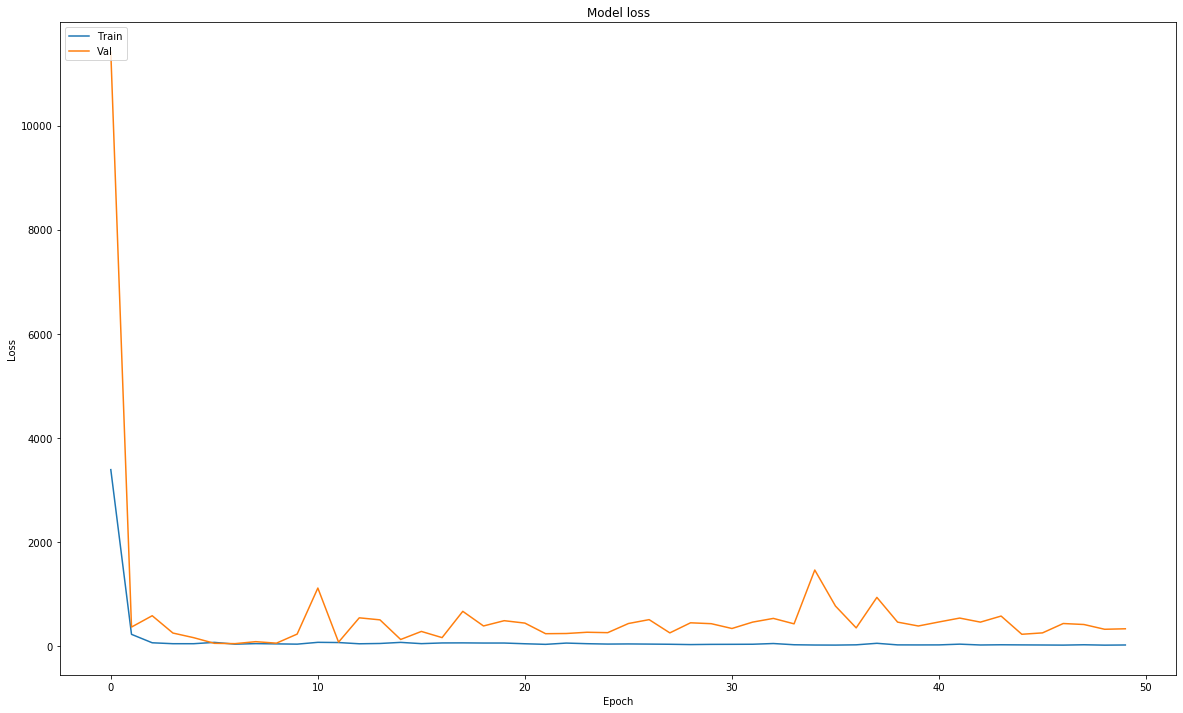

In [268]:
# Plot training & validation loss values
plt.figure(figsize=(20,12))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


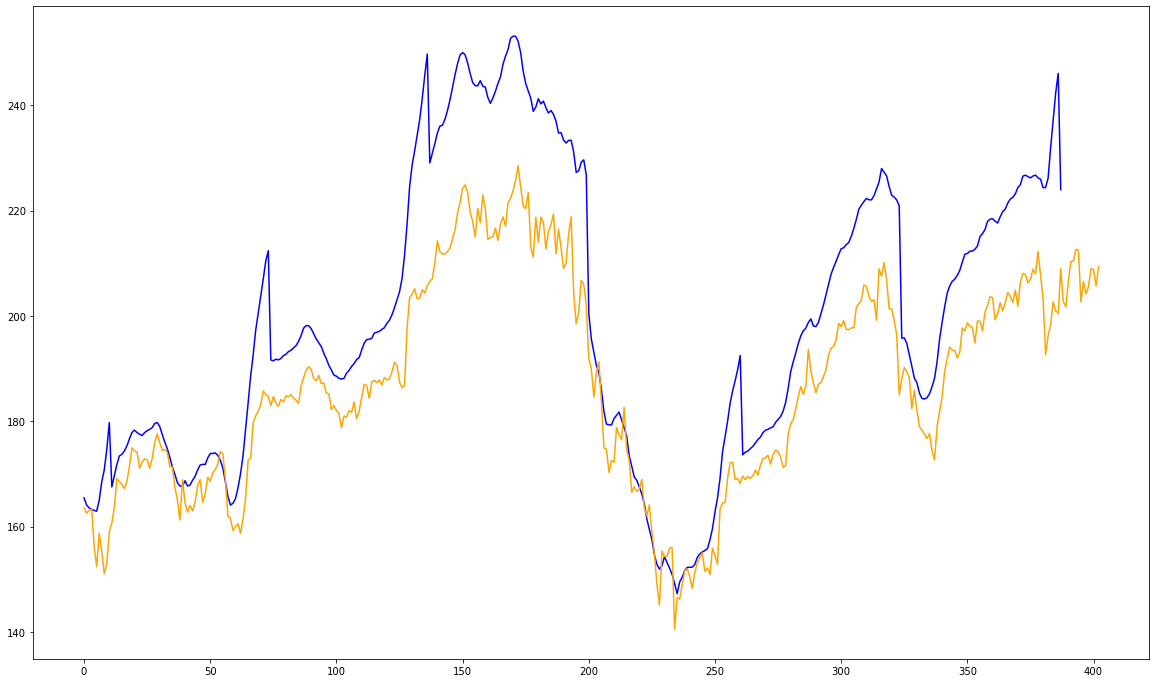

In [272]:
model.load_weights('weights-improvement-07-53.77.hdf5')

model.compile(optimizer='adam', loss='mse')

y_pred = model.predict_generator(val_data_generator)

plt.figure(figsize=(20,12))

plt.plot(y_pred, color='blue')
plt.plot(y_val, color='orange');

The model appears to be generalizing well, but with definite room for improvement. I would like to test this across multiple targets to see if it generalizes well via other time series. It's time to automate.

In [8]:
%cd exploratory_modeling

/home/azel/github/Data-Science/jupyter_notebooks/exploratory_modeling


In [9]:
apple = DailyTimeSeries('AAPL')
df = apple.initiate()
df.head()

################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  2019-09-04 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################


,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount
date,,,,,,,
1999-09-07,73.750,77.938,73.500,76.375,2.3805,246198400.0,0.0
1999-09-08,76.188,77.688,74.500,74.500,2.3220,190551200.0,0.0
1999-09-09,75.500,75.938,73.875,75.563,2.3552,133520800.0,0.0
1999-09-10,76.000,77.688,74.688,77.438,2.4136,114690800.0,0.0
1999-09-13,77.063,77.063,74.813,75.000,2.3376,63000000.0,0.0


In [10]:
def get_target(df, target, time_shift=1):
    """
    Selects a target by shifting a specific column 
    by one timestep. Then seperates the training data 
    and target into X and y respectively. 
    
    ###############
    Parameters:
    ###############
    
    df: Timeseries dataframe created by fin_data
    target: percent_move or existing feature shifted by 
            timeshift.
    timeshift: number of timesteps to shift the feature by.
    
    """
    if target == 'percent_move':

        df['target'] = ((df['AAPL_adjusted_close'].shift(-1) -
                         df['AAPL_adjusted_close']) / 
                        (df['AAPL_adjusted_close']))*100
    
    elif target == 'abs_percent_move':
        
        df['target'] = np.abs(((df['AAPL_adjusted_close'].shift(-1) -
                                df['AAPL_adjusted_close']) / 
                               (df['AAPL_adjusted_close']))*100)

    else:

        df['target'] = df[target].shift(-time_shift)
        
    df = df.dropna()
    
    X = df.drop(columns='target')
    y = df[['target']].values
    
    return X, y

In [11]:
def prep_data(train_cut, val_cut, X, y):
    
    scaler = MinMaxScaler()
    scaler.fit(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=train_cut, 
                                                        shuffle=False)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                    train_size=val_cut,
                                                    shuffle=False)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [12]:
def create_generators(X_train, X_test, X_val, y_train, y_test, y_val):

    train_data_generator = TimeseriesGenerator(X_train, y_train, 
                                               length=15,
                                               sampling_rate=1, 
                                               stride=1, 
                                               batch_size=6)

    test_data_generator = TimeseriesGenerator(X_test, y_test, 
                                              length=15, 
                                              sampling_rate=1,
                                              stride=1,
                                              batch_size=6)

    val_data_generator = TimeseriesGenerator(X_val, y_val, 
                                              length=15, 
                                              sampling_rate=1,
                                              stride=1,
                                              batch_size=6)
    
    return train_data_generator, test_data_generator, val_data_generator

In [328]:
def extract_data(generator):
    for i in np.arange(len(generator)):
        if i == 0:
            a, b = generator[i]
        else: 
            c, d = generator[i]

            a = np.vstack((a, c))
            b = np.vstack((b, d))
            
    return a, b

In [331]:
def prep_work(df, target, train_cut=0.8, val_cut=0.6):
    
    X, y = get_target(df=df, target=target)
    
    X_train, X_test, X_val, y_train, y_test, y_val=prep_data(train_cut=train_cut,
                                                             val_cut=val_cut,
                                                             X=X, y=y)
    
    train_data_generator, test_data_generator, val_data_generator = create_generators(X_train, 
                                                                                      X_test, 
                                                                                      X_val, 
                                                                                      y_train, 
                                                                                      y_test, 
                                                                                      y_val)
    
    data, y_val = extract_data(val_data_generator)
    
    return train_data_generator, test_data_generator, val_data_generator, y_val, X_train

In [18]:
def create_model(train_data_generator, X_train):
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', 
                   return_sequences=True, 
                   input_shape=(train_data_generator.length, 
                                X_train.shape[1])))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True,
                   activation='relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    
    return model
    

In [15]:
def fit_model(train_data_generator, 
              test_data_generator,
              filepath, 
              model):
    
    checkpointer = ModelCheckpoint(filepath=filepath, 
                               verbose=0, 
                               save_best_only=True)

    callbacks_list = [checkpointer]

    history = model.fit_generator(train_data_generator, 
                                  epochs = 100,
                                  validation_data=test_data_generator,
                                  verbose=0,
                                  callbacks=callbacks_list)
    
    return history

In [37]:
pm_train, pm_test, pm_val, pm_y_val, pm_X_train = prep_work(df=df, target='percent_move')
abs_train, abs_test, abs_val, abs_y_val, abs_X_train = prep_work(df=df, target='abs_percent_move')
close_train, close_test, close_val, close_y_val, close_X_train = prep_work(df=df, target='AAPL_close')
adj_train, adj_test, adj_val, adj_y_val, adj_X_train = prep_work(df=df, target='AAPL_adjusted_close')

pm_filepath = 'pm_checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5'
abs_filepath = 'abs_checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5'
close_filepath = 'close_checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5'
adj_filepath = 'adj_checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5'

pm_model = create_model(pm_train, pm_X_train)
abs_model = create_model(abs_train, abs_X_train)
close_model = create_model(close_train, close_X_train)
adj_model = create_model(adj_train, adj_X_train)

pm_history = fit_model(pm_train, pm_test, pm_filepath, pm_model)
print('#### Model 1 Trained ####')
abs_history = fit_model(abs_train, abs_test, abs_filepath, abs_model)
print('#### Model 2 Trained ####')
adj_history = fit_model(adj_train, adj_test, adj_filepath, adj_model)
print('#### Model 3 Trained ####')
close_history = fit_model(close_train, close_test, close_filepath, close_model)
print('#### Model 4 Trained ####')

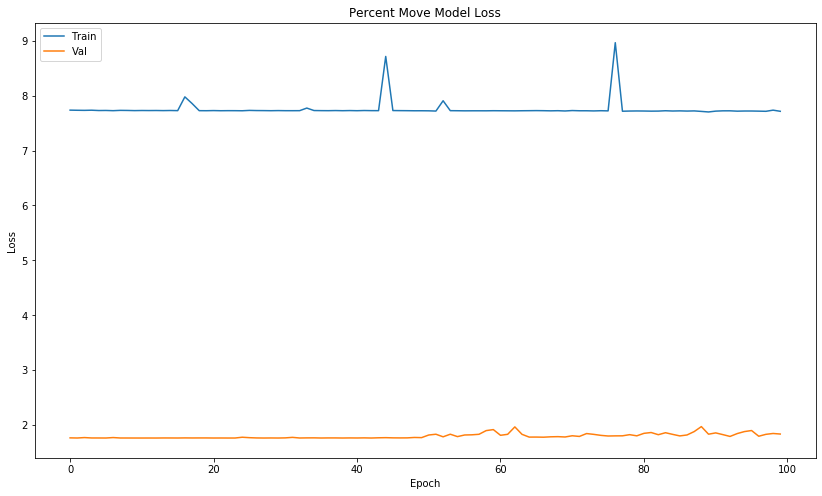

In [27]:
plt.figure(figsize=(14,8))
plt.plot(pm_history.history['loss'])
plt.plot(pm_history.history['val_loss'])
plt.title('Percent Move Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

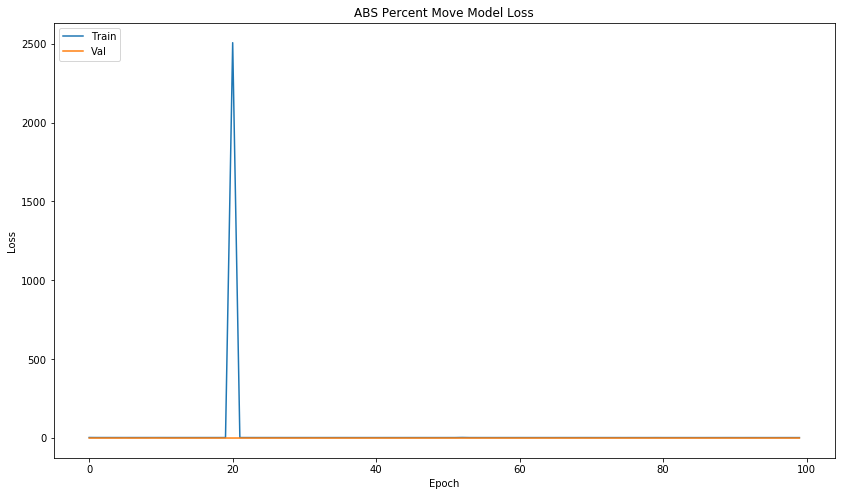

In [28]:
plt.figure(figsize=(14,8))
plt.plot(abs_history.history['loss'])
plt.plot(abs_history.history['val_loss'])
plt.title('ABS Percent Move Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

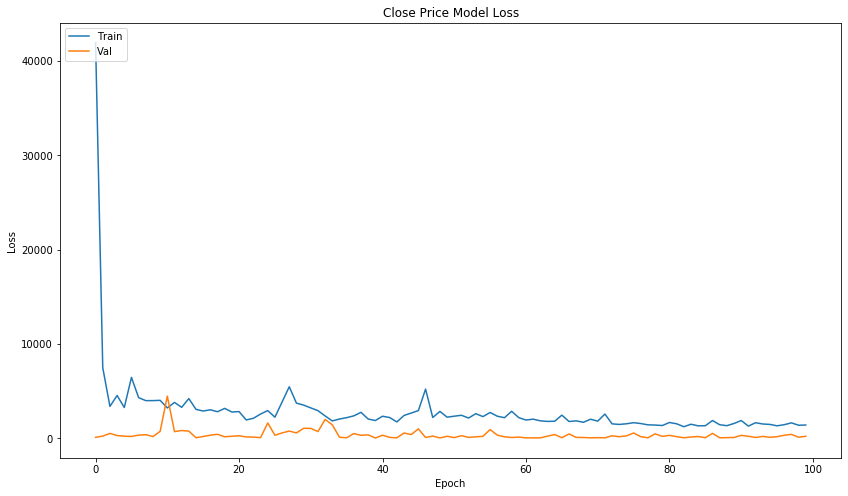

In [33]:
plt.figure(figsize=(14,8))
plt.plot(close_history.history['loss'])
plt.plot(close_history.history['val_loss'])
plt.title('Close Price Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

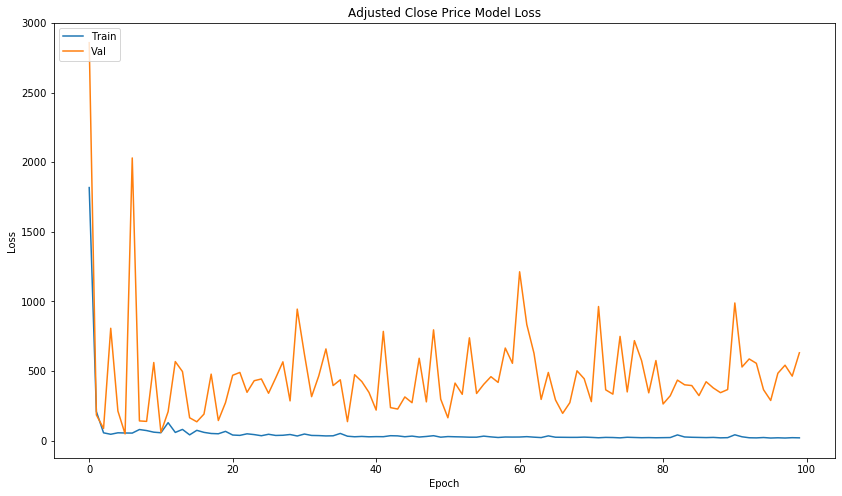

In [34]:
plt.figure(figsize=(14,8))
plt.plot(adj_history.history['loss'])
plt.plot(adj_history.history['val_loss'])
plt.title('Adjusted Close Price Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

In [324]:
list_of_files = glob.glob('pm_checkpoints/*.hdf5') 
latest_file = max(list_of_files, key=os.path.getctime)

pm_model.load_weights(latest_file)

pm_model.compile(optimizer='adam', loss='mse')

y_pred = pm_model.predict_generator(pm_val)

plt.figure(figsize=(20,12))
plt.title('Percent Move Prediction')
plt.plot(y_pred, color='blue')
plt.plot(pm_y_val, color='orange');

NameError: name 'pm_val' is not defined

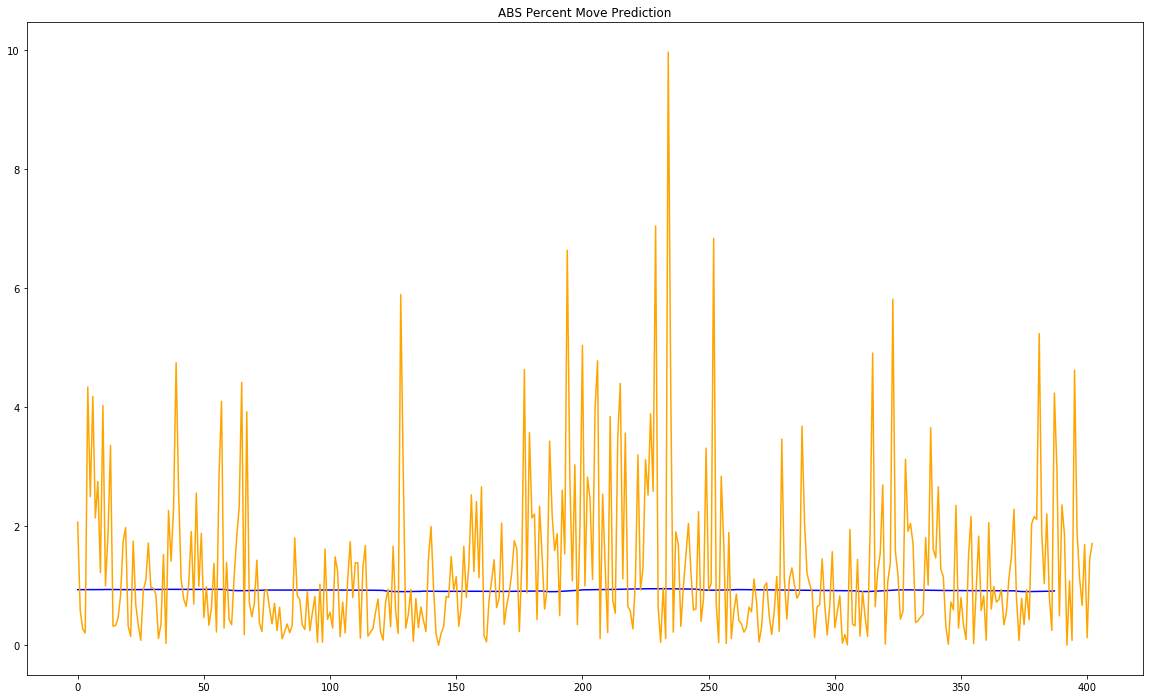

In [325]:
list_of_files = glob.glob('abs_checkpoints/*.hdf5') 
latest_file = max(list_of_files, key=os.path.getctime)

abs_model.load_weights(latest_file)

abs_model.compile(optimizer='adam', loss='mse')

y_pred = abs_model.predict_generator(abs_val)

plt.figure(figsize=(20,12))
plt.title('ABS Percent Move Prediction')
plt.plot(y_pred, color='blue')
plt.plot(abs_y_val, color='orange');

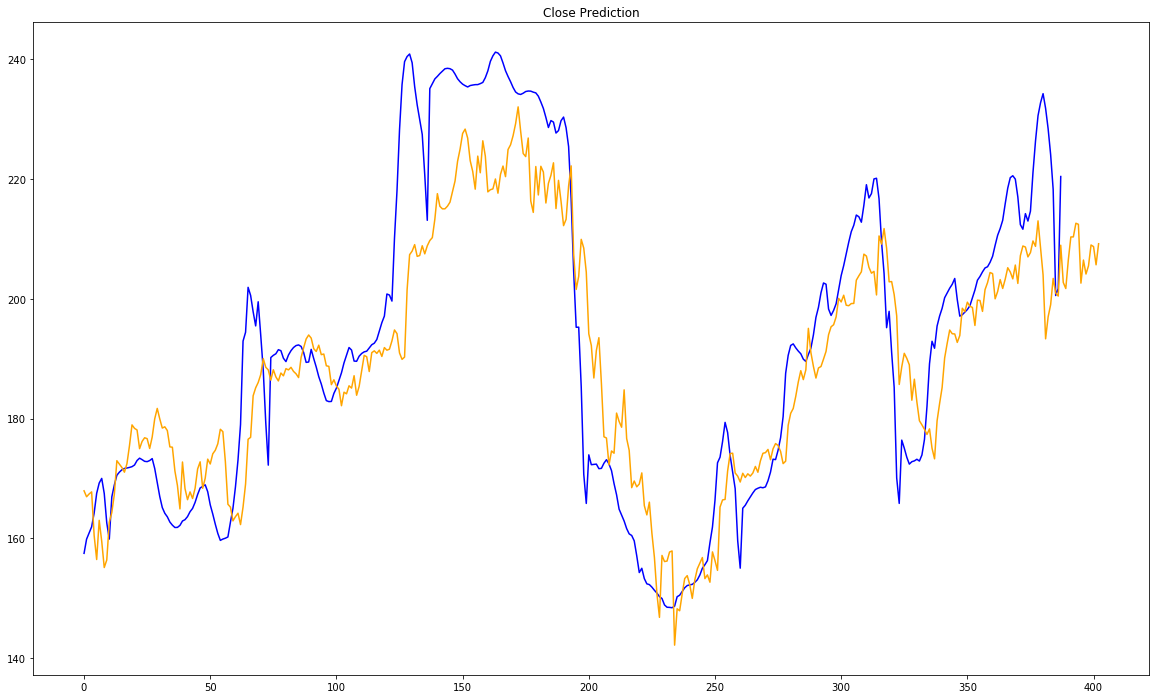

In [326]:
list_of_files = glob.glob('close_checkpoints/*.hdf5') 
latest_file = max(list_of_files, key=os.path.getctime)

close_model.load_weights(latest_file)

close_model.compile(optimizer='adam', loss='mse')

y_pred = close_model.predict_generator(close_val)

plt.figure(figsize=(20,12))
plt.title('Close Prediction')
plt.plot(y_pred, color='blue')
plt.plot(close_y_val, color='orange');

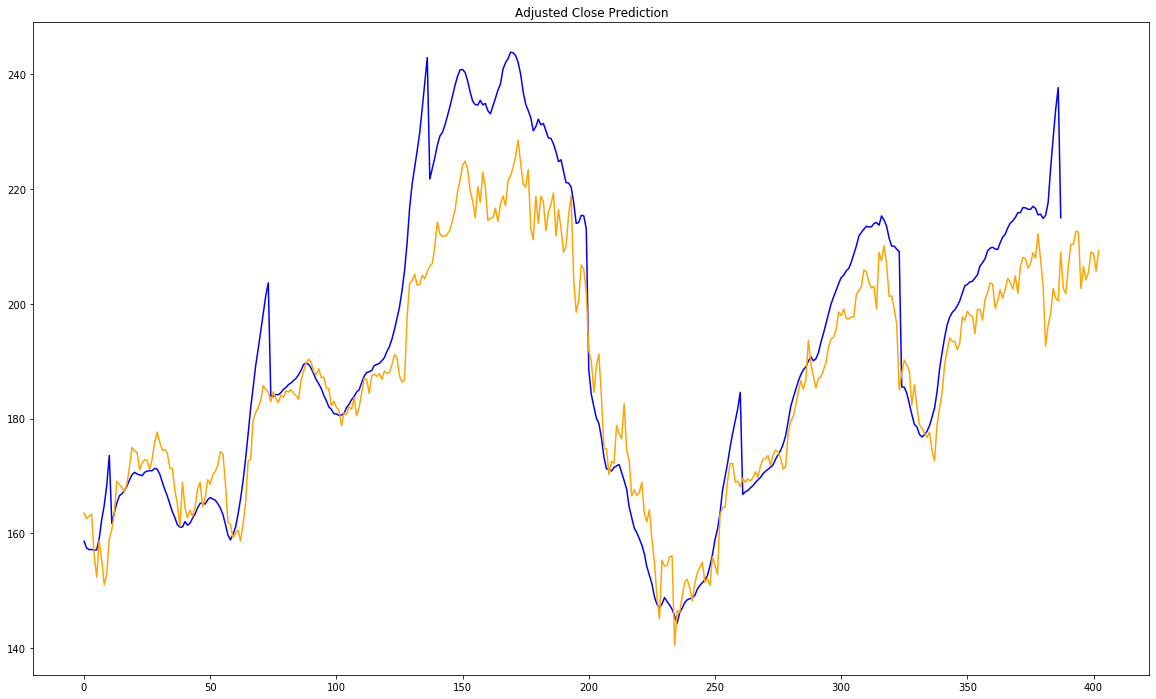

In [327]:
list_of_files = glob.glob('adj_checkpoints/*.hdf5') 
latest_file = max(list_of_files, key=os.path.getctime)

adj_model.load_weights(latest_file)

adj_model.compile(optimizer='adam', loss='mse')

y_pred = adj_model.predict_generator(adj_val)

plt.figure(figsize=(20,12))
plt.title('Adjusted Close Prediction')
plt.plot(y_pred, color='blue')
plt.plot(adj_y_val, color='orange');

In [322]:
def tech_company_data(ticker):
    """
    Containes Tech Index
    """    
    dts = DailyTimeSeries(ticker)
    df = dts.initiate()
    with HiddenPrints():
        df = dts.add_securities(['XLK', 'vix', 'SPX'], primary_df=df)
        df = dts.add_technicals(['SMA', 'EMA', 'MACD', 'STOCH', 
                                   'RSI', 'ADX', 'CCI', 'BBANDS', 
                                   'AD', 'OBV'], 
                                  primary_df=df)
        df = dts.add_macro(primary_df=df, 
                             indices=['trade_index', 'longterm_rates'])
    
    return df

df = tech_company_data('AAPL')
df.head()

################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  2019-09-04 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################


KeyError: "['8. split coefficient'] not found in axis"

In [ ]:
pm_train, pm_test, pm_val, pm_y_val, pm_X_train = prep_work(df=df, target='percent_move')
abs_train, abs_test, abs_val, abs_y_val, abs_X_train = prep_work(df=df, target='abs_percent_move')
close_train, close_test, close_val, close_y_val, close_X_train = prep_work(df=df, target='AAPL_close')
adj_train, adj_test, adj_val, adj_y_val, adj_X_train = prep_work(df=df, target='AAPL_adjusted_close')

pm_filepath = 'pm_checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5'
abs_filepath = 'abs_checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5'
close_filepath = 'close_checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5'
adj_filepath = 'adj_checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5'

pm_model = create_model(pm_train, pm_X_train)
abs_model = create_model(abs_train, abs_X_train)
close_model = create_model(close_train, close_X_train)
adj_model = create_model(adj_train, adj_X_train)

pm_history = fit_model(pm_train, pm_test, pm_filepath, pm_model)
print('#### Model 1 Trained ####')
abs_history = fit_model(abs_train, abs_test, abs_filepath, abs_model)
print('#### Model 2 Trained ####')
adj_history = fit_model(adj_train, adj_test, adj_filepath, adj_model)
print('#### Model 3 Trained ####')
close_history = fit_model(close_train, close_test, close_filepath, close_model)
print('#### Model 4 Trained ####')

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(pm_history.history['loss'])
plt.plot(pm_history.history['val_loss'])
plt.title('Percent Move Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(abs_history.history['loss'])
plt.plot(abs_history.history['val_loss'])
plt.title('ABS Percent Move Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(close_history.history['loss'])
plt.plot(close_history.history['val_loss'])
plt.title('Close Price Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(adj_history.history['loss'])
plt.plot(adj_history.history['val_loss'])
plt.title('Adjusted Close Price Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

In [ ]:
list_of_files = glob.glob('pm_checkpoints/*.hdf5') 
latest_file = max(list_of_files, key=os.path.getctime)

pm_model.load_weights(latest_file)

pm_model.compile(optimizer='adam', loss='mse')

y_pred = pm_model.predict_generator(pm_val)

plt.figure(figsize=(20,12))
plt.title('Percent Move Prediction')
plt.plot(y_pred, color='blue')
plt.plot(pm_y_val, color='orange');

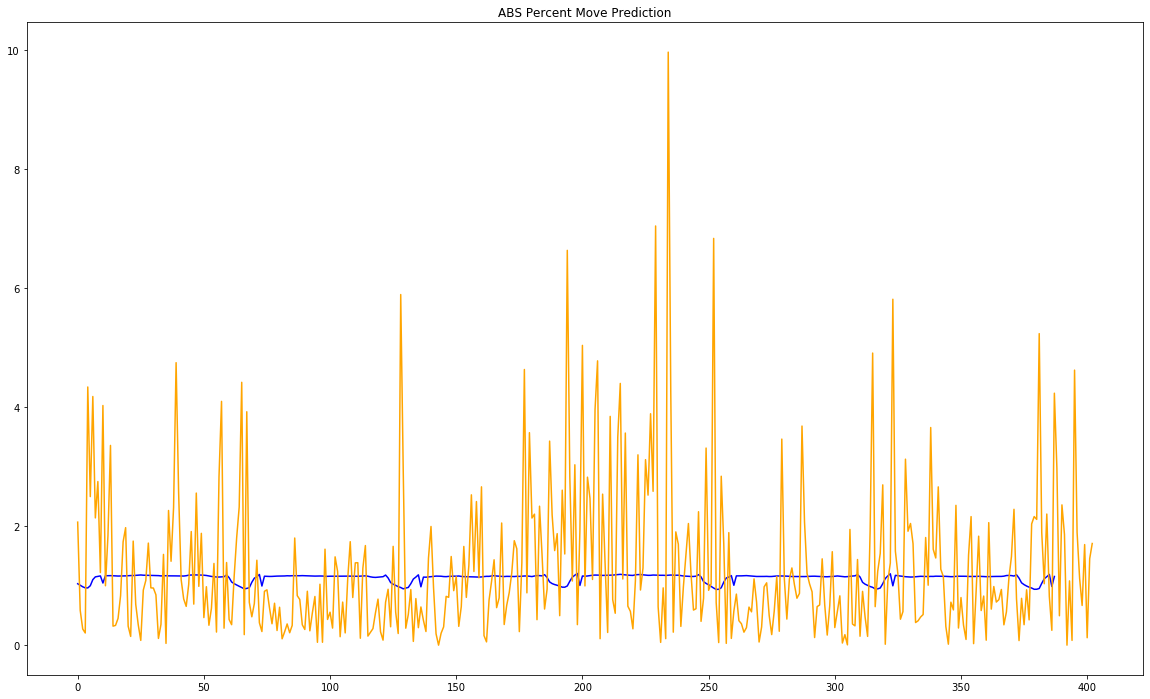

In [319]:
list_of_files = glob.glob('abs_checkpoints/*.hdf5') 
latest_file = max(list_of_files, key=os.path.getctime)

abs_model.load_weights(latest_file)

abs_model.compile(optimizer='adam', loss='mse')

y_pred = abs_model.predict_generator(abs_val)

plt.figure(figsize=(20,12))
plt.title('ABS Percent Move Prediction')
plt.plot(y_pred, color='blue')
plt.plot(abs_y_val, color='orange');

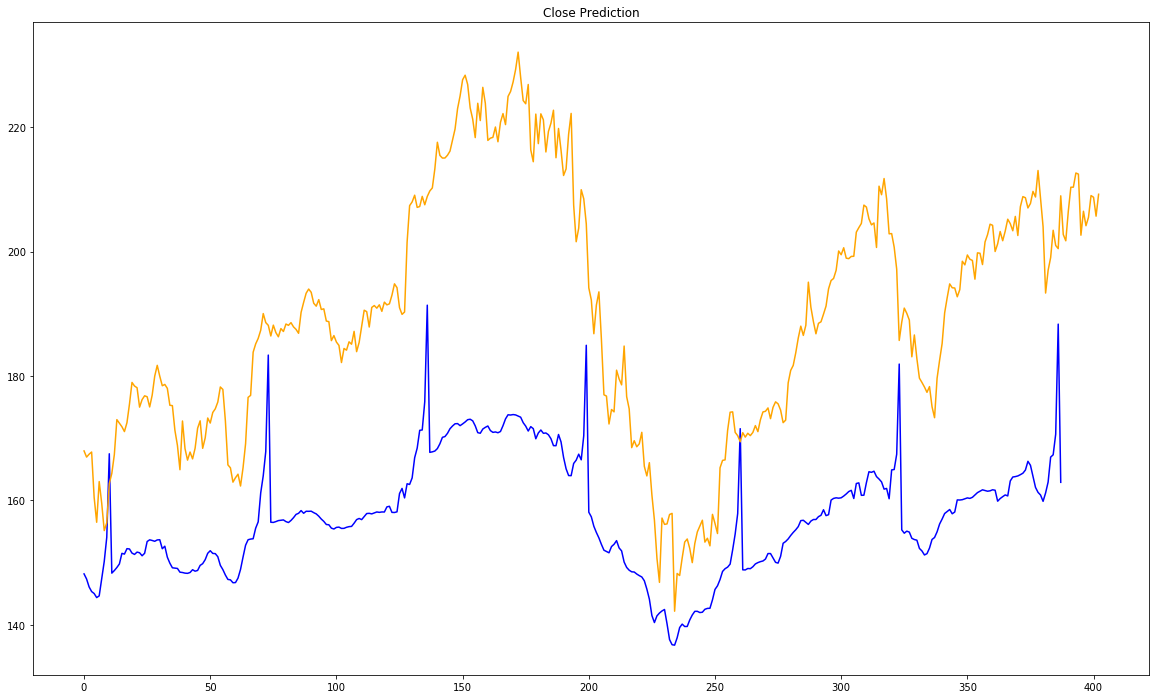

In [320]:
list_of_files = glob.glob('close_checkpoints/*.hdf5') 
latest_file = max(list_of_files, key=os.path.getctime)

close_model.load_weights(latest_file)

close_model.compile(optimizer='adam', loss='mse')

y_pred = close_model.predict_generator(close_val)

plt.figure(figsize=(20,12))
plt.title('Close Prediction')
plt.plot(y_pred, color='blue')
plt.plot(close_y_val, color='orange');

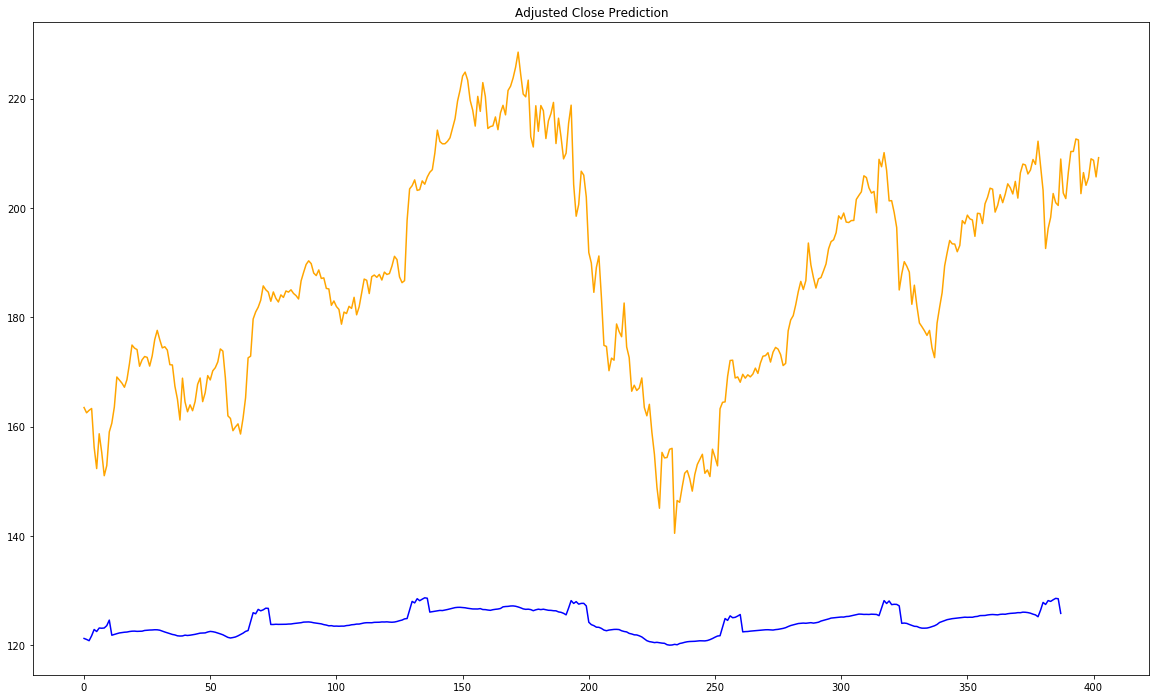

In [321]:
list_of_files = glob.glob('adj_checkpoints/*.hdf5') 
latest_file = max(list_of_files, key=os.path.getctime)

adj_model.load_weights(latest_file)

adj_model.compile(optimizer='adam', loss='mse')

y_pred = adj_model.predict_generator(adj_val)

plt.figure(figsize=(20,12))
plt.title('Adjusted Close Prediction')
plt.plot(y_pred, color='blue')
plt.plot(adj_y_val, color='orange');